# Investigating Fibroblast Migration in a Wound Healing Assay Using AI-Based Image Segmentation

### This Jupyter Notebook documents the complete pipeline from preprocessing to training and visualization of results using U-Net and a basic CNN for fibroblast wound healing assay segmentation.

In [17]:
# import os
from tifffile import imread
import numpy as np
import random
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

# SETUP PATHS 
tif_path = "/Users/seshasai/Downloads/Sesha_sample_data.tif"
save_image_dir = "/Users/seshasai/Desktop/data/images"
save_mask_dir = "/Users/seshasai/Desktop/data/masks"
os.makedirs(save_image_dir, exist_ok=True)
os.makedirs(save_mask_dir, exist_ok=True)

# LOAD TIFF 
img_stack = imread(tif_path)  # shape: (T, H, W) or (Z, T, H, W)
if img_stack.ndim == 4:
    img_stack = img_stack[:, 0, :, :]  # Convert (Z, T, H, W) → (T, H, W)

print(f"Loaded {img_stack.shape[0]} frames.")

#  PROCESS EACH FRAME 
for i in tqdm(range(img_stack.shape[0])):
    img16 = img_stack[i]

    # Contrast stretch to 8-bit
    p2, p98 = np.percentile(img16, (2, 98))
    img8 = np.clip((img16 - p2) / (p98 - p2) * 255, 0, 255).astype(np.uint8)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_eq = clahe.apply(img8)

    # Gaussian blur
    blurred = cv2.GaussianBlur(img_eq, (5, 5), 0)

    # Otsu's threshold
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

    # Remove small blobs
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(mask_clean)
    for cnt in contours:
        if cv2.contourArea(cnt) > 200:  # You can adjust this value
            cv2.drawContours(final_mask, [cnt], -1, 255, -1)

    # Save output
    cv2.imwrite(f"{save_image_dir}/frame_{i:03d}.png", img_eq)
    cv2.imwrite(f"{save_mask_dir}/frame_{i:03d}_mask.png", final_mask)


Loaded 145 frames.


100%|█████████████████████████████████████████| 145/145 [00:08<00:00, 16.35it/s]


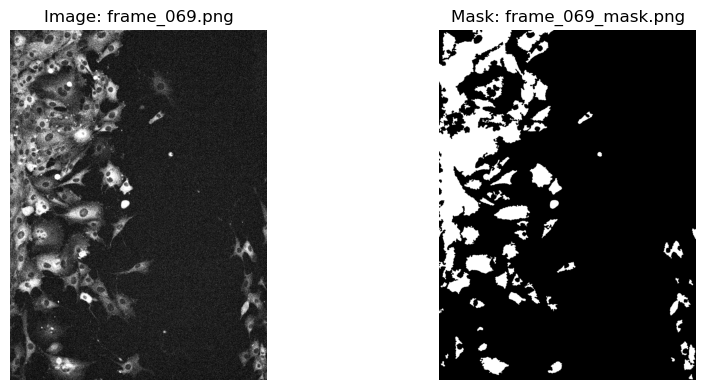

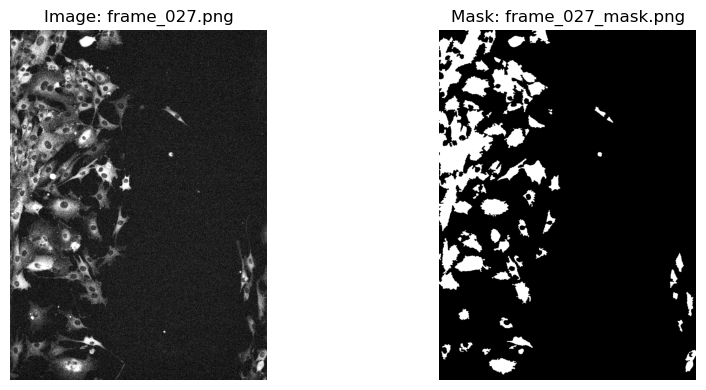

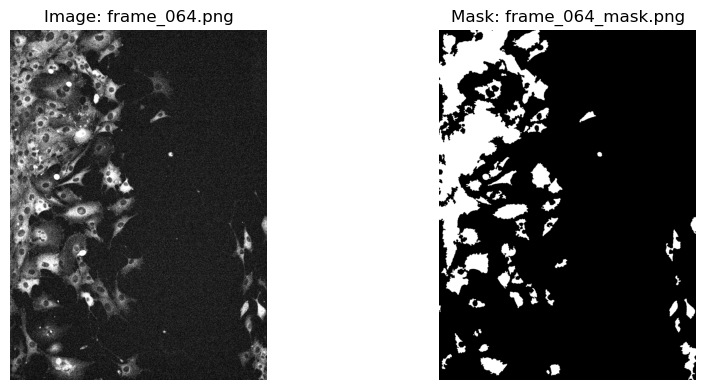

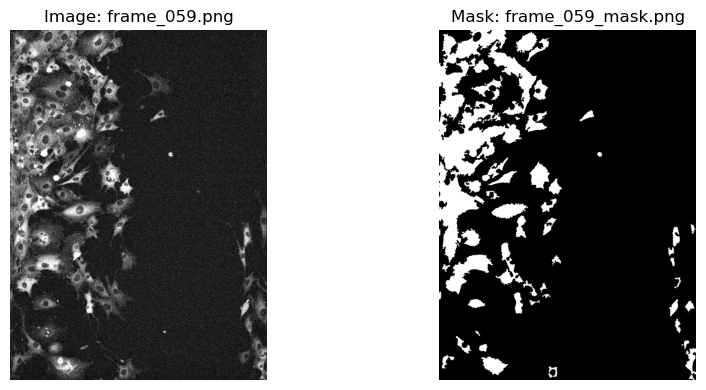

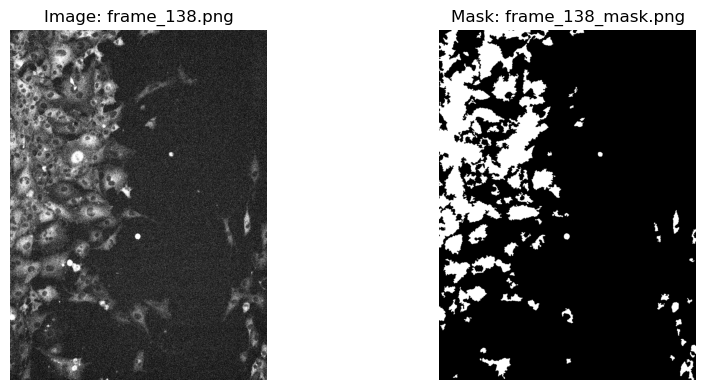

In [18]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Set up paths to images and masks
image_folder = "/Users/seshasai/Desktop/data/images"
mask_folder = "/Users/seshasai/Desktop/data/masks"

# Get sorted list of image and mask files
image_list = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])
mask_list = sorted([f for f in os.listdir(mask_folder) if f.endswith('.png')])

# Choose a few random samples to display
sample_count = 5
chosen_indices = random.sample(range(len(image_list)), sample_count)

# Loop through selected samples
for i in chosen_indices:
    img_file = os.path.join(image_folder, image_list[i])
    mask_file = os.path.join(mask_folder, mask_list[i])
    
    # Load grayscale images
    image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

    # Plot the original and corresponding mask
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Image: {image_list[i]}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask: {mask_list[i]}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


## 🔧 U-Net for Fibroblast Wound Edge Segmentation

In this section, we implement a **U-Net** architecture tailored for biomedical image segmentation. The model is trained to predict binary masks that outline the fibroblast wound area from grayscale microscopy images.

- **Architecture Overview:**
  - U-Net consists of an encoder-decoder structure with skip connections that help retain spatial information while learning deeper semantic features.
  - It is well-suited for medical imaging tasks where precise localization is crucial.

- **Training Details:**
  - The dataset is loaded using a custom PyTorch `Dataset` class.
  - A combination of **Binary Cross-Entropy (BCE)** and **Dice Loss** is used to optimize the model.
  - The model is trained over 10 epochs, and Dice scores for both training and validation sets are recorded at each epoch.
  - The best-performing weights are saved as `small_unet_cpu.pth`.

- **Visualization:**
  - After training, a random image from the dataset is passed through the U-Net model.
  - The predicted mask is smoothed using a Gaussian filter.
  - Contours of the predicted wound region are extracted and overlaid on the original image for visual inspection of the model's segmentation performance.


Epoch 1/10: 100%|█████████████████████████████| 116/116 [04:15<00:00,  2.20s/it]


Epoch 1 | Train Dice: 0.2383 | Val Dice: 0.2505


Epoch 2/10: 100%|█████████████████████████████| 116/116 [04:14<00:00,  2.20s/it]


Epoch 2 | Train Dice: 0.7004 | Val Dice: 0.9048


Epoch 3/10: 100%|█████████████████████████████| 116/116 [04:14<00:00,  2.19s/it]


Epoch 3 | Train Dice: 0.9095 | Val Dice: 0.9122


Epoch 4/10: 100%|█████████████████████████████| 116/116 [04:05<00:00,  2.11s/it]


Epoch 4 | Train Dice: 0.9114 | Val Dice: 0.9127


Epoch 5/10: 100%|█████████████████████████████| 116/116 [03:51<00:00,  2.00s/it]


Epoch 5 | Train Dice: 0.9117 | Val Dice: 0.9129


Epoch 6/10: 100%|█████████████████████████████| 116/116 [03:43<00:00,  1.92s/it]


Epoch 6 | Train Dice: 0.9119 | Val Dice: 0.9137


Epoch 7/10: 100%|█████████████████████████████| 116/116 [04:03<00:00,  2.10s/it]


Epoch 7 | Train Dice: 0.9125 | Val Dice: 0.9137


Epoch 8/10: 100%|█████████████████████████████| 116/116 [03:58<00:00,  2.06s/it]


Epoch 8 | Train Dice: 0.9122 | Val Dice: 0.9142


Epoch 9/10: 100%|█████████████████████████████| 116/116 [04:10<00:00,  2.16s/it]


Epoch 9 | Train Dice: 0.9126 | Val Dice: 0.9144


Epoch 10/10: 100%|████████████████████████████| 116/116 [04:21<00:00,  2.25s/it]


Epoch 10 | Train Dice: 0.9129 | Val Dice: 0.9144
✅ Model saved as small_unet_cpu.pth


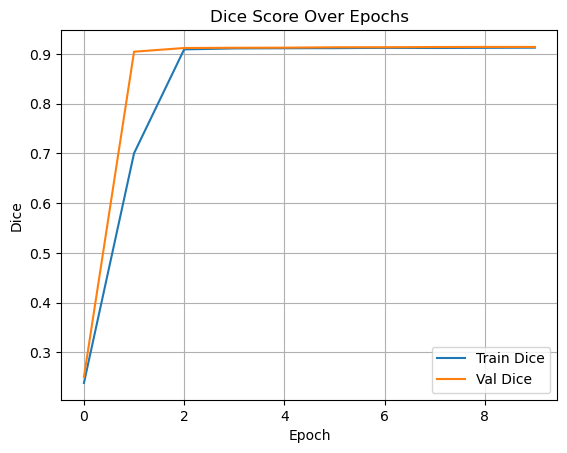

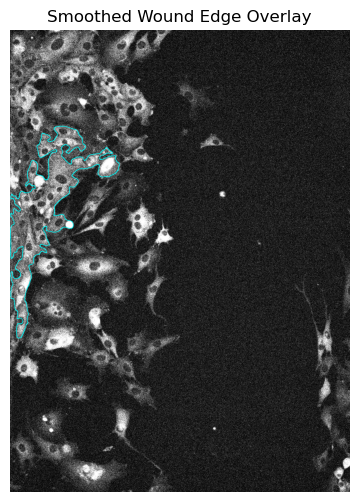

In [19]:
# Imports 
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Custom PyTorch Dataset Class for Wound Healing Images 
class WoundDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_list=None, augment=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        # Use provided image list or get all .png files from the directory
        self.image_files = image_list if image_list else sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
        self.augment = augment  # Whether to apply data augmentation

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load grayscale image and corresponding binary mask
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.image_files[idx].replace(".png", "_mask.png"))

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

        # Normalize image to [0, 1]
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        # Binarize the mask (assumes threshold of 127)
        mask = (mask > 127).astype(np.float32)

        # Convert to PyTorch tensors and add channel dimension
        image = torch.tensor(image).unsqueeze(0)
        mask = torch.tensor(mask).unsqueeze(0)

        # Data Augmentation (only if self.augment is True) 
        if self.augment:
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            if random.random() > 0.5:
                angle = random.uniform(-15, 15)
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)
            if random.random() > 0.5:
                image = image + 0.05 * torch.randn_like(image)  # Add Gaussian noise
                image = torch.clamp(image, 0.0, 1.0)

        return image, mask

#  Mini U-Net Architecture 
class MiniDeepUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder (Downsampling path)
        self.enc1 = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(8, 16, 3, padding=1), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())

        # Pooling layer to reduce size
        self.pool = nn.MaxPool2d(2)

        # Decoder (Upsampling path)
        self.up2 = nn.ConvTranspose2d(32, 16, 2, stride=2)  # Upsample and halve channels
        self.dec2 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU())  # Combine with encoder feature map
        self.up1 = nn.ConvTranspose2d(16, 8, 2, stride=2)
        self.dec1 = nn.Sequential(nn.Conv2d(16, 8, 3, padding=1), nn.ReLU())

        # Final 1x1 conv layer to output a single-channel prediction
        self.out = nn.Conv2d(8, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Downsampling
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Upsampling and concatenation with encoder features
        d2 = self.up2(e3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.sigmoid(self.out(d1))

# Dice Metrics 
def dice_loss(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def dice_score(pred, target, smooth=1.0):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

#  U-Net Training Pipeline
def train_unet_cpu():
    from sklearn.model_selection import train_test_split

    device = torch.device('cpu')

    # Image + mask paths
    image_dir = "/Users/seshasai/Desktop/data/images"
    mask_dir = "/Users/seshasai/Desktop/data/masks"

    # Prepare data 
    all_images = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
    train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

    train_dataset = WoundDataset(image_dir, mask_dir, image_list=train_images, augment=True)
    val_dataset = WoundDataset(image_dir, mask_dir, image_list=val_images, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    #  Model, optimizer, loss 
    model = MiniDeepUNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    bce = nn.BCELoss()

    num_epochs = 10
    train_dice_list = []
    val_dice_list = []

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_dice = 0.0, 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)
            preds = model(images)

            # Combine BCE and Dice Loss for segmentation
            loss = bce(preds, masks) + dice_loss(preds, masks)
            score = dice_score(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_dice += score.item()

        avg_train_dice = total_dice / len(train_loader)
        train_dice_list.append(avg_train_dice)

        #  Validation pass 
        model.eval()
        val_dice = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                preds = model(images)
                val_dice += dice_score(preds, masks).item()

        avg_val_dice = val_dice / len(val_loader)
        val_dice_list.append(avg_val_dice)

        print(f"Epoch {epoch+1} | Train Dice: {avg_train_dice:.4f} | Val Dice: {avg_val_dice:.4f}")

    # Save trained model
    torch.save(model.state_dict(), "small_unet_cpu.pth")
    print("✅ Model saved as small_unet_cpu.pth")

    # Plot Dice Scores 
    plt.plot(train_dice_list, label='Train Dice')
    plt.plot(val_dice_list, label='Val Dice')
    plt.title("Dice Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.legend()
    plt.grid()
    plt.show()

    return model, train_dataset

#  Visualization Function for Predicted Wound Edges 
def show_monolayer_border(model, dataset, device='cpu'):
    import scipy.ndimage as ndi

    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    image, _ = dataset[idx]
    image_batch = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_mask = model(image_batch).squeeze().cpu().numpy()

    # Apply smoothing and binarization
    pred_binary = (pred_mask > 0.5).astype(np.uint8)
    pred_smooth = ndi.gaussian_filter(pred_binary.astype(float), sigma=1.5)
    pred_binary_smooth = (pred_smooth > 0.4).astype(np.uint8) * 255

    # Prepare original grayscale image for visualization
    input_img = (image.squeeze().cpu().numpy() * 255).astype(np.uint8)
    input_color = cv2.cvtColor(input_img, cv2.COLOR_GRAY2BGR)

    # Extract contours from predicted mask
    contours, _ = cv2.findContours(pred_binary_smooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        coords = max_contour.squeeze()

        if len(coords.shape) == 2:
            coords = ndi.gaussian_filter1d(coords.astype(float), sigma=3, axis=0)
            coords = coords.astype(int).reshape(-1, 1, 2)
            cv2.drawContours(input_color, [coords], -1, (0, 255, 255), 2)  # Yellow contour

    # Display result
    plt.figure(figsize=(8, 6))
    plt.imshow(input_color)
    plt.title("Smoothed Wound Edge Overlay")
    plt.axis("off")
    plt.show()

# Run training + visualization 
if __name__ == "__main__":
    model, dataset = train_unet_cpu()
    show_monolayer_border(model, dataset)


## 🧠 BasicCNN for Baseline Segmentation Comparison

To benchmark performance, we also implement a **BasicCNN** model as a simpler alternative to U-Net. This helps evaluate how a shallow network compares on the same wound segmentation task.

- **Architecture Overview:**
  - BasicCNN consists of a few convolutional layers without skip connections or encoder-decoder structure.
  - It serves as a baseline to understand the impact of model complexity on segmentation quality.

- **Training Details:**
  - The model is trained using the same dataset and loss functions (BCE + Dice Loss) as the U-Net.
  - Training and validation Dice scores are computed at each epoch to evaluate learning progress.
  - Despite its simplicity, BasicCNN is able to converge reasonably well and reaches high Dice scores by the final epochs.

- **Visualization:**
  - A randomly chosen validation image is passed through the trained BasicCNN model.
  - The output mask is thresholded and smoothed.
  - Contours of the predicted wound edge are drawn on the grayscale image to compare visual performance with U-Net.

This comparison highlights how architectural choices affect model performance, with U-Net typically offering more precise and reliable segmentations in biomedical contexts.


Epoch 1/10: 100%|█████████████████████████████| 116/116 [00:54<00:00,  2.12it/s]


Epoch 1 | Train Dice: 0.8676 | Val Dice: 0.8893


Epoch 2/10: 100%|█████████████████████████████| 116/116 [00:53<00:00,  2.17it/s]


Epoch 2 | Train Dice: 0.8883 | Val Dice: 0.8771


Epoch 3/10: 100%|█████████████████████████████| 116/116 [00:54<00:00,  2.15it/s]


Epoch 3 | Train Dice: 0.8747 | Val Dice: 0.8836


Epoch 4/10: 100%|█████████████████████████████| 116/116 [00:55<00:00,  2.07it/s]


Epoch 4 | Train Dice: 0.8940 | Val Dice: 0.9029


Epoch 5/10: 100%|█████████████████████████████| 116/116 [00:53<00:00,  2.16it/s]


Epoch 5 | Train Dice: 0.9029 | Val Dice: 0.9050


Epoch 6/10: 100%|█████████████████████████████| 116/116 [00:54<00:00,  2.12it/s]


Epoch 6 | Train Dice: 0.9045 | Val Dice: 0.9062


Epoch 7/10: 100%|█████████████████████████████| 116/116 [00:53<00:00,  2.18it/s]


Epoch 7 | Train Dice: 0.9057 | Val Dice: 0.9067


Epoch 8/10: 100%|█████████████████████████████| 116/116 [00:54<00:00,  2.13it/s]


Epoch 8 | Train Dice: 0.9057 | Val Dice: 0.9065


Epoch 9/10: 100%|█████████████████████████████| 116/116 [00:53<00:00,  2.15it/s]


Epoch 9 | Train Dice: 0.9060 | Val Dice: 0.9073


Epoch 10/10: 100%|████████████████████████████| 116/116 [00:54<00:00,  2.14it/s]


Epoch 10 | Train Dice: 0.9065 | Val Dice: 0.9075


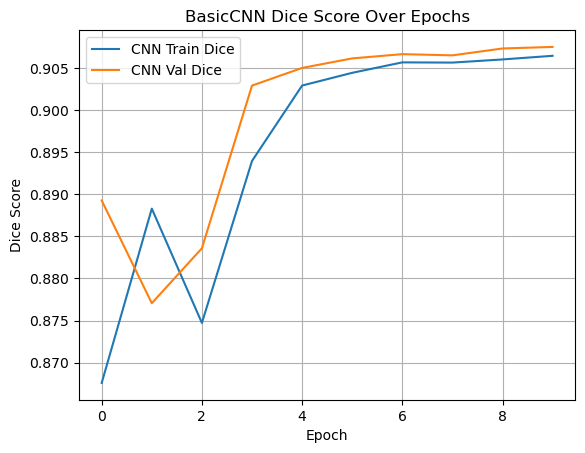

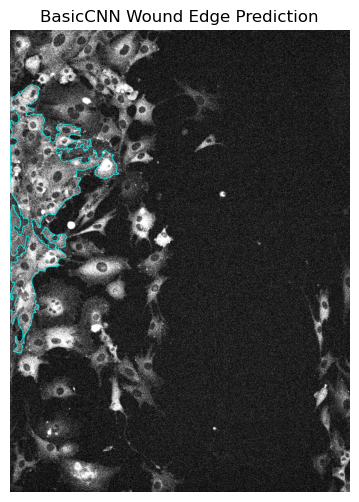

In [20]:
from sklearn.model_selection import train_test_split

# --- BASIC CNN Model ---
# This is a very lightweight convolutional neural network for image segmentation.
# It uses downsampling (via MaxPooling) and upsampling (via bilinear interpolation)
# to perform an encoder-decoder style segmentation on grayscale wound images.
class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),  # First convolution: 1 input channel (grayscale), 8 output channels
            nn.ReLU(),                      # Non-linear activation
            nn.MaxPool2d(2),                # Downsampling to reduce spatial dimensions
            nn.Conv2d(8, 16, 3, padding=1), # Second convolution: increase depth
            nn.ReLU(),                      # Non-linear activation again
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Upsample to original size
            nn.Conv2d(16, 1, 1),            # Final convolution to reduce to 1 channel output mask
            nn.Sigmoid()                    # Sigmoid to output probabilities between 0 and 1
        )

    def forward(self, x):
        return self.net(x)

# Data Preparation 

# Set the paths to the image and mask directories
image_dir = "/Users/seshasai/Desktop/data/images"
mask_dir = "/Users/seshasai/Desktop/data/masks"

# Get list of all image filenames (assumes .png format)
all_images = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

# Split image dataset into training and validation sets (80/20 split)
train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

# Create dataset objects using a custom WoundDataset class
# `augment=True` for training to apply random data augmentation
train_dataset = WoundDataset(image_dir, mask_dir, image_list=train_images, augment=True)
val_dataset = WoundDataset(image_dir, mask_dir, image_list=val_images, augment=False)

# Create PyTorch DataLoaders to load data in batches
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)   # Batch size 1 for simplicity
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Training Function 
# This function trains the model, evaluates Dice score, and logs performance
def train_model(model, train_loader, val_loader, num_epochs=10, device='cpu'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer with a small learning rate
    bce = nn.BCELoss()  # Binary cross-entropy loss for segmentation tasks
    train_dice_list = []
    val_dice_list = []

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_dice = 0.0, 0.0

        # Training loop
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)
            preds = model(images)  # Forward pass to get predictions
            loss = bce(preds, masks) + dice_loss(preds, masks)  # Combined BCE + Dice loss
            score = dice_score(preds, masks)  # Evaluate dice score (higher is better)

            optimizer.zero_grad()
            loss.backward()      # Backpropagate the error
            optimizer.step()     # Update model weights

            total_loss += loss.item()
            total_dice += score.item()

        # Track average train Dice score for this epoch
        avg_train_dice = total_dice / len(train_loader)
        train_dice_list.append(avg_train_dice)

        # Validation phase
        model.eval()
        val_dice = 0.0
        with torch.no_grad():  # No gradient calculation needed during eval
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                preds = model(images)
                val_dice += dice_score(preds, masks).item()

        avg_val_dice = val_dice / len(val_loader)
        val_dice_list.append(avg_val_dice)

        print(f"Epoch {epoch+1} | Train Dice: {avg_train_dice:.4f} | Val Dice: {avg_val_dice:.4f}")

    return model, train_dice_list, val_dice_list

# Visualization Function 
# Visualize one prediction from the validation set using matplotlib and OpenCV
def visualize_prediction(model, dataset, device='cpu'):
    import scipy.ndimage as ndi
    model.eval()
    idx = random.randint(0, len(dataset)-1)  # Pick a random sample
    image, _ = dataset[idx]
    image_batch = image.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        pred_mask = model(image_batch).squeeze().cpu().numpy()  # Predict mask

    # Binarize the mask with threshold 0.5
    pred_binary = (pred_mask > 0.5).astype(np.uint8)

    # Apply Gaussian smoothing for visual effect
    pred_smooth = ndi.gaussian_filter(pred_binary.astype(float), sigma=1.5)
    pred_binary_smooth = (pred_smooth > 0.4).astype(np.uint8) * 255

    # Convert grayscale image to color for drawing
    input_img = (image.squeeze().cpu().numpy() * 255).astype(np.uint8)
    input_color = cv2.cvtColor(input_img, cv2.COLOR_GRAY2BGR)

    # Detect contours in the predicted mask and draw them on the original image
    contours, _ = cv2.findContours(pred_binary_smooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        coords = max_contour.squeeze()
        if len(coords.shape) == 2:
            coords = ndi.gaussian_filter1d(coords.astype(float), sigma=3, axis=0).astype(int).reshape(-1, 1, 2)
            cv2.drawContours(input_color, [coords], -1, (0, 255, 255), 2)  # Yellow contour

    # Plot the result
    plt.figure(figsize=(8, 6))
    plt.imshow(input_color)
    plt.title("BasicCNN Wound Edge Prediction")
    plt.axis("off")
    plt.show()


#  RUN BASIC CNN TRAINING + EVAL + VIS 

# Choose device (CPU in this case)
device = torch.device('cpu')

# Instantiate the model
basic_cnn = BasicCNN()

# Train the model and collect training/validation dice scores
basic_cnn, cnn_train_dice, cnn_val_dice = train_model(basic_cnn, train_loader, val_loader, num_epochs=10, device=device)

# Plot the Dice scores across epochs
plt.plot(cnn_train_dice, label="CNN Train Dice")
plt.plot(cnn_val_dice, label="CNN Val Dice")
plt.title("BasicCNN Dice Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()
plt.grid()
plt.show()

# Show one visualized prediction from validation set
visualize_prediction(basic_cnn, val_dataset, device)
